In [1]:
import ROOT
import pandas as pd
from copy import deepcopy

from utils.H4RecoRDFLoader import LoadH4RecoData

ROOT.gROOT.Macro('../setStyle.C')
ROOT.gROOT.LoadMacro('../FPCanvasStyle.C')

Welcome to JupyROOT 6.18/00


0

In [2]:
runlist = pd.read_csv('data/intercalibration18deg.csv', header=None, names=['run', 'energy', 'position', 'table_x', 'table_y', 'n_events'])

h4df = LoadH4RecoData(files=['/eos/user/s/spigazzi/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v8/ECAL_H4_October2018_%d.root' % run for run in runlist['run']])

h4df = h4df.Filter('n_tracks==1 && fabs(X[0]+5)<5 && fabs(Y[0]-4)< 2')

dfs = {}

channels = ['A1', 'A2', 'A3',
           'B1', 'B2', 'B3', 'B4', 'B5',
           'C1', 'C2', 'C3', 'C4', 'C5',
           'D1', 'D2', 'D3', 'D4', 'D5',
           'E1', 'E2', 'E3']

h4df = h4df.Define('trk_x', 'X[0]+5')
h4df = h4df.Define('trk_y', 'Y[0]-4')
for ch in channels:
    #dfs[ch] = h4df.Filter('run==%d'%runlist.loc[runlist['position']==ch, 'run'])
    dfs[ch] = h4df.Filter('Positions=="%s"'%ch)
    dfs[ch] = dfs[ch].Define('ampl_%s'%ch, 'fit_ampl[%s]*ampl_calib[%s]'%(ch,ch))    
    dfs[ch] = dfs[ch].Define('time_%s'%ch, 'fit_time[%s]'%ch)
    dfs[ch] = dfs[ch].Define('dt_mcp1_%s'%ch, 'time_%s-fit_time[MCP1]+fit_time[VFE_CLK]-int((time_%s-fit_time[MCP1]+fit_time[VFE_CLK])/6.238)*6.238'%(ch,ch))
    dfs[ch] = dfs[ch].Define('dt_mcp2_%s'%ch, 'time_%s-fit_time[MCP2]+fit_time[VFE_CLK]-int((time_%s-fit_time[MCP2]+fit_time[VFE_CLK])/6.238)*6.238'%(ch,ch))    


Warning in <TClass::Init>: no dictionary for class PositionMeasurement is available
Warning in <TClass::Init>: no dictionary for class TrackPar is available
Warning in <TClass::Init>: no dictionary for class Tracking::TelescopeLayer is available
Warning in <TClass::Init>: no dictionary for class Tracking::TelescopeLayout is available
Warning in <TClass::Init>: no dictionary for class CfgManager is available



****************************************
Minimizer is Linear
Chi2                      =      38.7469
NDf                       =            7
p0                        =     0.735891   +/-   0.000492282 
p1                        =  -0.00118943   +/-   0.00013355  
p2                        = -0.000434762   +/-   5.14056e-05 

****************************************
Minimizer is Linear
Chi2                      =      5.60272
NDf                       =            7
p0                        =     0.858175   +/-   0.00159179  
p1                        =  -0.00185184   +/-   0.00045234  
p2                        =  0.000384694   +/-   0.000170815 

****************************************
Minimizer is Linear
Chi2                      =      14.7573
NDf                       =            7
p0                        =      1.15224   +/-   0.000449706 
p1                        =  -0.00148963   +/-   0.000118379 
p2                        =  0.000565225   +/-   4.59769e-05 


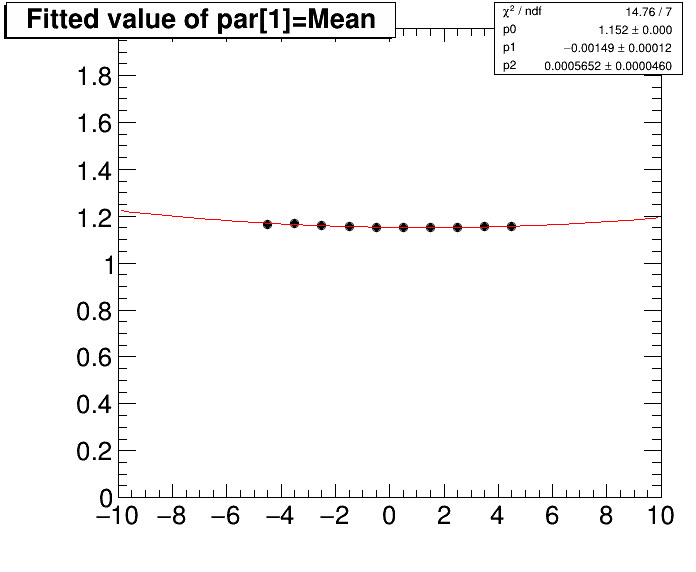

In [5]:
pr_time = {}
for ch in ['C2', 'D3', 'C3']:
    df = dfs[ch]
    pr = df.Histo2D(('pr_t_%s'%ch, '', 20, -10, 10, 100, 0, 2), 'trk_x', 'dt_mcp2_%s'%ch)
    
    c = ROOT.TCanvas()
    fgaus = ROOT.TF1("fgaus", "gaus", 0, 2)
    pr.FitSlicesY(fgaus)
    pr_time[ch] = deepcopy(ROOT.gDirectory.Get('pr_t_%s_1'%ch))
    pr_time[ch].SetAxisRange(0, 2, "Y")
    pr_time[ch].Fit('pol2')
    pr_time[ch].Draw('')
    c.Draw()

In [4]:
fC2 = pr_time['C2'].GetFunction('pol2')
fC3 = pr_time['C3'].GetFunction('pol2')
fC4 = pr_time['D3'].GetFunction('pol2')

print(fC2.Eval(fC2.GetParameter(1)/(2*fC2.GetParameter(2)))-fC3.Eval(fC3.GetParameter(1)/(2*fC3.GetParameter(2))))
print(fC4.Eval(fC4.GetParameter(1)/(2*fC4.GetParameter(2)))-fC3.Eval(fC3.GetParameter(1)/(2*fC3.GetParameter(2))))

-0.42173154886250397
-0.2903209782113716
